<a href="https://colab.research.google.com/github/HaroldSthid/blueprint_LnagChain_RagAgentic/blob/main/Script_LangGraph_para_Colab_y_Diagrama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # Agente de Preguntas y Respuestas con LangGraph y RAG (Versión Colab)
### Este script implementa un agente capaz de responder preguntas utilizando:
#### 1. Una base de conocimiento local (RAG - Retrieval Augmented Generation) creada desde una página web.
#### 2. Búsqueda web (Tavily) si la información local no es suficiente o la pregunta es compleja.
#### 3. Modelos de Lenguaje Grandes (LLMs) de Groq para la generación y evaluación.
#### 4. LangGraph para orquestar el flujo de trabajo.


# ## 🔧 **PASO 1: Instalación de Dependencias**
### Estas son las bibliotecas de Python que necesitamos. El comando `!pip` las instala en el entorno de Colab.
#### El `-q` es para una instalación "silenciosa" (menos texto en la salida).

In [ ]:
%pip -q install langchain langgraph chromadb tavily-python groq
%pip -q install langchain_community langchain_text_splitters sentence-transformers
%pip -q install langchainhub python-dotenv ipywidgets # Eliminé pytest ya que no escribiremos tests aquí directamente

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.7 MB/s eta 

# ## 🔐 **PASO 2: Configuración de Claves API**
#### Necesitarás claves API para Groq (LLMs), Tavily (búsqueda web) y opcionalmente LangSmith (trazabilidad).
#### **IMPORTANTE:** Reemplaza `"gsk_xxx"`, `"tvly-xxx"`, y `"ls__xxx"` con TUS claves API reales.
#### En Colab, puedes pegar tus claves directamente aquí para una prueba rápida. Para mayor seguridad en proyectos, considera usar el gestor de "Secretos" de Colab (en el panel izquierdo, icono de llave).


In [ ]:
import os
from google.colab import userdata

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY') # ¡REEMPLAZA ESTA CLAVE CON TU CLAVE DE GROQ!
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY') # ¡REEMPLAZA ESTA CLAVE CON TU CLAVE DE TAVILY!
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY') # ¡REEMPLAZA ESTA CLAVE! (Opcional, para LangSmith)
# Si no usas LangSmith, puedes comentar la línea de LANGCHAIN_API_KEY o dejarla con un valor placeholder.

#### 2. Habilitar LangSmith Tracing V2 (Recomendado)
#####Esto asegura que estás utilizando la última y mejor versión de la trazabilidad de LangChain.
#### 3. Nombre del Proyecto en LangSmith (Opcional pero Muy Recomendado para Organización)
##### Las trazas de esta ejecución se agruparán bajo este nombre de proyecto en la UI de LangSmith.
##### Cámbialo por un nombre descriptivo para tu proyecto.
#### 4. Endpoint de LangSmith (Generalmente no es necesario cambiarlo)
##### Solo necesitarías modificar esto si tienes una instancia auto-hospedada de LangSmith.

In [ ]:
# 2.
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [ ]:
# 3.
os.environ["LANGCHAIN_PROJECT"] = "Agente RAG Colab v2 - LangSmith"

In [ ]:
# 4.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

#### Verifica que las claves se hayan establecido (opcional)

In [ ]:
print(f"GROQ_API_KEY: {os.getenv('GROQ_API_KEY')[:5]}...") # Muestra solo los primeros 5 caracteres por seguridad

GROQ_API_KEY: gsk_E...


In [ ]:
print("--- LangSmith Configuration ---")
print(f"LANGCHAIN_API_KEY: {os.getenv('LANGCHAIN_API_KEY')[:5]}..." if os.getenv('LANGCHAIN_API_KEY') else "No establecida - LangSmith no funcionará")
print(f"LANGCHAIN_TRACING_V2: {os.getenv('LANGCHAIN_TRACING_V2')}")
print(f"LANGCHAIN_PROJECT: {os.getenv('LANGCHAIN_PROJECT')}")
print(f"LANGCHAIN_ENDPOINT: {os.getenv('LANGCHAIN_ENDPOINT', 'https://api.smith.langchain.com (default)')}")

--- LangSmith Configuration ---
LANGCHAIN_API_KEY: lsv2_...
LANGCHAIN_TRACING_V2: true
LANGCHAIN_PROJECT: Agente RAG Colab v2 - LangSmith
LANGCHAIN_ENDPOINT: https://api.smith.langchain.com


# ## 📚 **PASO 3: Creación de la Base de Conocimiento RAG (Vector Store)**
#### Vamos a cargar información de una página web (Wikipedia sobre LangChain en español), dividirla en fragmentos, crear representaciones numéricas (embeddings) de estos fragmentos, y almacenarlos en una base de datos vectorial (ChromaDB). Esto permitirá al agente buscar información relevante localmente.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader  # ✅
from langchain_text_splitters import RecursiveCharacterTextSplitter  # ✅
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import os # Necesario para la comprobación de directorio

### --- Configuración de la Base de Datos Vectorial ---
#### Usamos un modelo de embedding eficiente que se ejecuta localmente.

In [ ]:
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
persist_directory = "./rag_db_colab_v2" # Directorio para guardar la BD vectorial en Colab

/tmp/ipython-input-226601275.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public mod

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### --- Comprobación para Evitar Recrear la BD Innecesariamente ---
#### Esto es útil si la sesión de Colab se interrumpe y quieres reanudar sin reprocesar.

In [ ]:
if not os.path.exists(persist_directory) or not os.listdir(persist_directory):
    print(f"Creando nueva base de datos vectorial en '{persist_directory}'...")
    # Cargar documentos desde una URL
    loader = WebBaseLoader(
        ["https://es.wikipedia.org/wiki/LangChain"],
        # podrías añadir más URLs a la lista: ["url1", "url2"]
    )
    docs = loader.load()
    print(f"Se cargaron {len(docs)} documento(s) desde la web.")

    # Dividir documentos en fragmentos más pequeños
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    print(f"Los documentos se dividieron en {len(splits)} fragmentos (chunks).")

    # Crear y persistir la base de datos vectorial
    # ChromaDB almacenará los embeddings de los fragmentos.
    vector_store = Chroma.from_documents(
        documents=splits,
        embedding=embedding_function,
        persist_directory=persist_directory
    )
    print("Base de datos vectorial creada y guardada.")
else:
    print(f"Cargando base de datos vectorial existente desde '{persist_directory}'...")
    vector_store = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding_function
    )
    print("Base de datos vectorial cargada.")

Creando nueva base de datos vectorial en './rag_db_colab_v2'...
Se cargaron 1 documento(s) desde la web.
Los documentos se dividieron en 3 fragmentos (chunks).
Base de datos vectorial creada y guardada.


# ## 🤖 **PASO 4: Configuración de Modelos de Lenguaje (LLMs)**
### Configuramos los LLMs que usaremos a través de Groq (que ofrece inferencia rápida):
#### - `llm_groq`: Un modelo potente (Llama 3 70B) para generar las respuestas finales.
#### - `grader_llm`: Un modelo más pequeño y rápido (Llama 3 8B) para tareas de evaluación interna.
#### La `temperature` controla la creatividad/aleatoriedad (0 = más determinista, >0 = más creativo).

In [ ]:
!pip install langchain-groq

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
# LLM principal para generación de respuestas
llm_groq = ChatGroq(
    temperature=0.1, # Un valor bajo para respuestas más factuales y consistentes
    model_name="llama3-70b-8192"
)

# LLM para tareas de evaluación (más pequeño y rápido)
grader_llm = ChatGroq(
    temperature=0, # Temperatura 0 para máxima consistencia en la evaluación
    model_name="llama3-8b-8192"
)

print("Modelos LLM de Groq configurados (generador y evaluador).")

Modelos LLM de Groq configurados (generador y evaluador).


# ## 🧑‍⚖️ **PASO 5: Definición de Cadenas de Evaluación (Grader)**
#### Creamos una "cadena" (usando LangChain Expression Language - LCEL) que utiliza el `grader_llm`
#### para evaluar si un documento recuperado es relevante para la pregunta del usuario.
#### Se le instruye para que responda con un JSON: `{"score": "yes"}` o `{"score": "no"}`.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

In [ ]:
# Plantilla de prompt para el evaluador de relevancia
retrieval_grader_prompt_template = """Eres un evaluador experto. Tu tarea es determinar si el siguiente DOCUMENTO es relevante para responder la PREGUNTA.
Considera únicamente el contenido del DOCUMENTO proporcionado.
Responde únicamente con una estructura JSON válida que contenga una sola clave "score".
El valor de "score" debe ser "yes" si el documento es relevante, o "no" si no lo es. No añadas explicaciones.

PREGUNTA:
{question}

DOCUMENTO:
{document}"""

retrieval_grader_prompt = ChatPromptTemplate.from_template(retrieval_grader_prompt_template)

# Cadena LCEL: Prompt -> LLM Evaluador -> Parser de JSON
retrieval_grader = retrieval_grader_prompt | grader_llm | JsonOutputParser()

print("Cadena de evaluación de relevancia (retrieval_grader) creada.")

Cadena de evaluación de relevancia (retrieval_grader) creada.


### Ejemplo de uso (opcional, para probar el evaluador):

In [ ]:
try:
    eval_test_result = retrieval_grader.invoke({
        "question": "¿Qué es LangChaing permite crear agentes?",
        "document": "LangChain es un framework para construir aplicaciones con LLMs. Permite encadenar componentes y crear agentes."
    })
    print("Resultado de prueba del evaluador:", eval_test_result) # Debería ser {"score": "yes"}
    eval_test_result_no = retrieval_grader.invoke({
        "question": "¿Cuál es el clima en Marte?",
        "document": "LangChain es un framework para construir aplicaciones con LLMs."
    })
    print("Resultado de prueba del evaluador (no relevante):", eval_test_result_no) # Debería ser {"score": "no"}
except Exception as e:
    print(f"Error en prueba de evaluador: {e}")

Error en prueba de evaluador: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}


# ## 🕸️ **PASO 6: Definición del Grafo con LangGraph (Estado y Nodos)**
### Aquí definimos la estructura de nuestro agente usando LangGraph.
#### 1. `GraphState`: Un diccionario tipado que mantiene el estado del proceso (pregunta, documentos, respuesta, etc.).
#### 2. Nodos (`retrieve_docs`, `tavily_web_search`, `generate_answer`): Funciones de Python que representan las acciones o pasos que el agente puede tomar. Cada nodo modifica el `GraphState`.


In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.messages import HumanMessage # Para encapsular la pregunta del usuario
from langgraph.graph import StateGraph, END # Componentes principales de LangGraph
from tavily import TavilyClient # Cliente para la API de Tavily

### --- 1. Definición del Estado del Grafo ---
#### TypedDict ayuda con el autocompletado y la verificación de tipos.
### --- 2. Definición de las Funciones de los Nodos ---
#### Cada nodo es una función que toma el estado actual y devuelve un diccionario
#### con las partes del estado que actualiza.

In [ ]:
# --- 1. Definición del Estado del Grafo ---
# TypedDict ayuda con el autocompletado y la verificación de tipos.
class GraphState(TypedDict):
    question: Union[str, HumanMessage] # La pregunta original del usuario
    documents: List[str]               # Lista de contenidos de documentos recuperados (de RAG o web)
    answer: str                        # La respuesta final generada por el LLM
    # Esta bandera indica si la lógica del grafo determinó que se necesita una búsqueda web,
    # o si la búsqueda web ya se realizó. Útil para la lógica condicional.
    web_search_performed: Annotated[bool, "Indica si la búsqueda web fue necesaria/realizada"] = False

# --- 2. Definición de las Funciones de los Nodos ---
# Cada nodo es una función que toma el estado actual y devuelve un diccionario
# con las partes del estado que actualiza.

def retrieve_docs_node(state: GraphState) -> dict:
    """
    Nodo para recuperar documentos de la base de datos vectorial (RAG).
    """
    print("--- Ejecutando Nodo: retrieve_docs_node ---")
    question_input = state["question"]
    # Extraer el contenido de la pregunta si es un HumanMessage
    question_content = question_input.content if isinstance(question_input, HumanMessage) else str(question_input)

    # Realizar búsqueda de similitud en la base de datos vectorial
    retrieved_docs_objects = vector_store.similarity_search(question_content, k=3) # Obtener los 3 más relevantes
    # Extraer solo el contenido de la página de los objetos Document
    doc_contents = [doc.page_content for doc in retrieved_docs_objects]

    if doc_contents:
        print(f"Se recuperaron {len(doc_contents)} fragmentos de la base de datos local (RAG).")
    else:
        print("No se encontraron documentos relevantes en la base de datos local (RAG).")
    return {"documents": doc_contents}

def tavily_web_search_node(state: GraphState) -> dict:
    """
    Nodo para realizar una búsqueda web utilizando Tavily API.
    """
    print("--- Ejecutando Nodo: tavily_web_search_node ---")
    question_input = state["question"]
    question_content = question_input.content if isinstance(question_input, HumanMessage) else str(question_input)

    print(f"Realizando búsqueda web con Tavily para: '{question_content}'")
    try:
        tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
        # `search_depth="basic"` es más rápido y a menudo suficiente.
        # `max_results` controla cuántos resultados obtener.
        response = tavily.search(query=question_content, max_results=3, search_depth="basic")
        web_results_content = [result["content"] for result in response.get("results", [])]
        if web_results_content:
            print(f"Se obtuvieron {len(web_results_content)} resultados de la búsqueda web.")
        else:
            print("La búsqueda web no arrojó resultados directos de contenido.")
        # Actualiza los documentos y marca que la búsqueda web se realizó
        return {"documents": web_results_content, "web_search_performed": True}
    except Exception as e:
        print(f"Error durante la búsqueda web con Tavily: {e}")
        return {"documents": [], "web_search_performed": True} # Continuar con documentos vacíos si falla

def generate_answer_node(state: GraphState) -> dict:
    """
    Nodo para generar una respuesta utilizando el LLM principal y el contexto de los documentos.
    """
    print("--- Ejecutando Nodo: generate_answer_node ---")
    question_input = state["question"]
    question_content = question_input.content if isinstance(question_input, HumanMessage) else str(question_input)
    documents = state["documents"]

    if not documents:
        print("Advertencia: No hay documentos de contexto para generar la respuesta. Se usará solo la pregunta.")
        context_str = "No se encontró información adicional relevante en las fuentes consultadas."
    else:
        # Unir los contenidos de los documentos para formar el contexto
        context_str = "\n\n---\n\n".join(documents)
        print(f"Contexto para la generación (primeros 200 caracteres): {context_str[:200]}...")

    # Crear el prompt para el LLM generador
    generation_prompt_template = f"""Eres un asistente de IA útil y conciso. Responde la PREGUNTA del usuario basándote únicamente en el CONTEXTO proporcionado.
Si el contexto no contiene la respuesta, indica que la información no está disponible en las fuentes consultadas.
No inventes información. Sé directo y ve al grano.

CONTEXTO:
{context_str}

PREGUNTA:
{question_content}

RESPUESTA:"""

    answer = llm_groq.invoke(generation_prompt_template).content
    print("Respuesta generada por el LLM.")
    return {"answer": answer}

print("Definición del estado y nodos del grafo LangGraph completada.")


Definición del estado y nodos del grafo LangGraph completada.


# ## 🚦 **PASO 7: Construcción y Compilación del Grafo (Lógica de Flujo)**
### Ahora conectamos los nodos para definir cómo fluye la información y las decisiones dentro del agente.
#### 1. Nodos: Añadimos los nodos definidos al `workflow`.
#### 2. Lógica Condicional (`route_initial_question_logic`, `grade_retrieved_documents_logic`): Funciones que deciden el siguiente paso basado en el estado actual.
#### 3. Aristas (Edges): Conectan los nodos. Pueden ser directas (`add_edge`) o condicionales (`add_conditional_edges`).
#### 4. Punto de Entrada y Compilación: Se establece el inicio del grafo y se compila en una aplicación ejecutable.

### --- Funciones para Lógica Condicional (Decisiones del Grafo) ---

In [ ]:
def route_initial_question_logic(state: GraphState) -> str:
    """
    Decide la ruta inicial: ¿buscar en la web directamente o intentar RAG local primero?
    Retorna el nombre del siguiente nodo a ejecutar.
    """
    print("--- Evaluando Ruta Inicial de la Pregunta (route_initial_question_logic) ---")
    question_input = state["question"]
    question_content = question_input.content if isinstance(question_input, HumanMessage) else str(question_input)

    # Palabras clave simples para decidir si es "compleja" y necesita web directamente.
    # Podrías hacer esto más sofisticado (ej. usando un LLM clasificador).
    keywords_for_web = ["actualidad", "noticias", "última información", "reciente", "tiempo real"]
    if any(keyword in question_content.lower() for keyword in keywords_for_web):
        print("Decisión: Pregunta parece requerir información actual. Dirigir a búsqueda web.")
        return "web_search_needed" # Nombre de la rama que lleva a web_searcher
    else:
        print("Decisión: Pregunta estándar. Intentar recuperación local (RAG) primero.")
        return "retrieve_first" # Nombre de la rama que lleva a retriever

def grade_retrieved_documents_logic(state: GraphState) -> str:
    """
    Evalúa los documentos recuperados (de RAG). Si no son relevantes o no hay, sugiere búsqueda web.
    Retorna el nombre del siguiente nodo o acción.
    """
    print("--- Evaluando Documentos Recuperados (grade_retrieved_documents_logic) ---")
    question_input = state["question"]
    question_content = question_input.content if isinstance(question_input, HumanMessage) else str(question_input)
    documents = state["documents"]
    web_search_already_performed = state.get("web_search_performed", False)

    # Si ya se hizo una búsqueda web (porque la ruta inicial fue directa a web o RAG falló y luego web),
    # no necesitamos evaluar de nuevo, vamos directamente a generar la respuesta.
    if web_search_already_performed:
        print("Decisión: Búsqueda web ya realizada en un paso anterior. Proceder a generar respuesta.")
        return "generate_with_web_docs" # Rama para generar

    if not documents:
        print("Decisión: No se recuperaron documentos de RAG. Se necesita búsqueda web.")
        return "web_search_needed_after_rag" # Rama para buscar en web

    print(f"Evaluando {len(documents)} documentos recuperados de RAG...")
    relevant_docs_count = 0
    for i, doc_content in enumerate(documents):
        # print(f"Evaluando relevancia del documento RAG {i+1}...")
        try:
            grade = retrieval_grader.invoke({"question": question_content, "document": doc_content})
            if grade.get("score") == "yes":
                # print(f"Documento RAG {i+1} considerado SÍ relevante.")
                relevant_docs_count += 1
            # else:
                # print(f"Documento RAG {i+1} considerado NO relevante.")
        except Exception as e:
            print(f"Error al evaluar documento RAG {i+1}: {e}. Asumiendo no relevante para seguridad.")
            # No se cuenta como relevante si hay error

    # Umbral: si menos de la mitad son relevantes (o ninguno), ir a web. Ajusta según necesidad.
    if relevant_docs_count < len(documents) / 2 and relevant_docs_count < 2 : # Si pocos son relevantes
        print(f"Decisión: Solo {relevant_docs_count}/{len(documents)} documentos RAG son relevantes. Se necesita búsqueda web.")
        return "web_search_needed_after_rag"
    else:
        print(f"Decisión: {relevant_docs_count}/{len(documents)} documentos RAG son relevantes. Proceder a generar respuesta.")
        return "generate_with_rag_docs"

### --- Construcción del Grafo ---

In [ ]:
workflow = StateGraph(GraphState)

# Añadir nodos al grafo
workflow.add_node("retriever_node", retrieve_docs_node)
workflow.add_node("web_searcher_node", tavily_web_search_node)
workflow.add_node("answer_generator_node", generate_answer_node)

# Establecer el punto de entrada condicional.
# LangGraph usa "__start__" como el identificador para el punto de inicio del grafo
# cuando la primera acción es una decisión condicional.
workflow.add_conditional_edges(
    "__start__", # Punto de inicio conceptual para la primera decisión
    route_initial_question_logic, # Función que toma la decisión
    { # Diccionario que mapea los posibles resultados de la función a los siguientes nodos
        "retrieve_first": "retriever_node",    # Si la función devuelve "retrieve_first", ir a retriever_node
        "web_search_needed": "web_searcher_node", # Si devuelve "web_search_needed", ir a web_searcher_node
    }
)

# Definir el flujo desde el recuperador de documentos (retriever_node)
workflow.add_conditional_edges(
    "retriever_node", # Nodo de origen
    grade_retrieved_documents_logic, # Función de decisión después de recuperar de RAG
    {
        "generate_with_rag_docs": "answer_generator_node", # Si los docs RAG son buenos, generar
        "web_search_needed_after_rag": "web_searcher_node",  # Si no, buscar en la web
    }
)

# Flujo después de la búsqueda web (web_searcher_node)
# Después de buscar en la web, siempre se intenta generar una respuesta.
workflow.add_edge("web_searcher_node", "answer_generator_node")

# Flujo final: después de generar la respuesta, el proceso termina.
workflow.add_edge("answer_generator_node", END) # END es un identificador especial de LangGraph

# Compilar el grafo para obtener una aplicación ejecutable
app = workflow.compile()
print("Grafo LangGraph construido y compilado exitosamente.")

Grafo LangGraph construido y compilado exitosamente.


In [ ]:
!pip install playwright; playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 19.8 MB/s eta 0:00:00
173.7 MiB [] 0% 11.1s173.7 MiB [] 0% 3.1s173.7 MiB [] 1% 2.4s173.7 MiB [] 2% 2.3s173.7 MiB [] 3% 2.0s173.7 MiB [] 4% 1.9s173.7 MiB [] 5% 1.9s173.7 MiB [] 6% 2.0s173.7 MiB [] 6% 2.1s173.7 MiB [] 7% 2.1s173.7 MiB [] 8% 2.0s173.7 MiB [] 9% 2.0s173.7 MiB [] 10% 2.0s173.7 MiB [] 11% 1.9s173.7 MiB [] 12% 1.9s173.7 MiB [] 13% 1.9s173.7 MiB [] 14% 1.8s173.7 MiB [] 15% 1.7s173.7 MiB [] 16% 1.7s173.7 MiB [] 17% 1.7s173.7 MiB [] 18% 1.6s173.7 MiB [] 19% 1.7s173.7 MiB [] 19% 1.8s173.7 MiB [] 19% 1.9s173.7 MiB [] 19% 2.0s173.7 MiB [] 20% 2.1s173.7 MiB [] 20% 2.2s173.7 MiB [] 20% 2.3s173.7 MiB [] 20% 2.4s173.7 MiB [] 20% 2.5s173.7 MiB [] 21% 2.5s173.7 MiB [] 21% 2.6s173.7 MiB [] 21% 2.7s173.7 MiB [] 21% 2.8s173.7 MiB [] 22% 2.8s173.7 MiB [] 22% 2.9s173.7 MiB [] 22% 3.0s173.7 MiB [] 23% 3.0s173.7 MiB [] 23% 3.1s173.7 MiB [] 24% 3.0s173.7 MiB [] 24% 3.1s173.7 MiB [] 25% 3.1s173.7 MiB [] 26% 3.1s173.7 MiB [] 26% 3.2s173.7 Mi

In [ ]:
from IPython.display import Image, display # Uncommented Image import

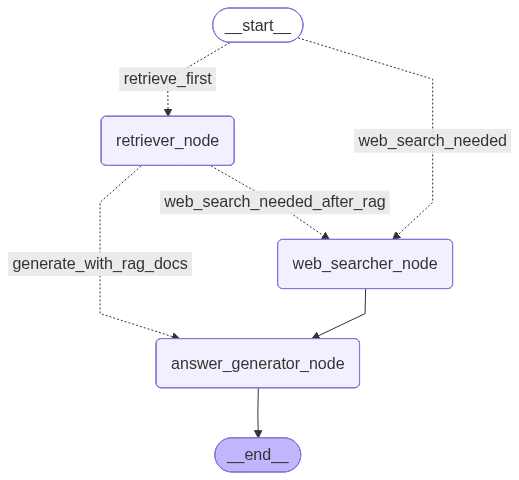

Si la imagen no se muestra, asegúrate de tener 'playwright' instalado y su navegador (`playwright install`).


In [ ]:
# Opcional: Visualizar el grafo (puede requerir dependencias adicionales en Colab)
# Esto genera una URL a una imagen del grafo si tienes las dependencias correctas.
# from IPython.display import Image, display
try:
     # Necesitarás instalar playwright: !pip install playwright; playwright install
     # y posiblemente otras dependencias de graphviz si draw_mermaid_png no funciona directamente.
     img_data = app.get_graph().draw_mermaid_png()
     display(Image(img_data))
     print("Si la imagen no se muestra, asegúrate de tener 'playwright' instalado y su navegador (`playwright install`).")
except Exception as e:
     print(f"No se pudo generar la imagen del grafo (puede requerir dependencias adicionales): {e}")
     print("Puedes copiar el código Mermaid del PASO 9 y pegarlo en https://mermaid.live para visualizarlo.")

# ## 🧪 **PASO 8: Ejecución y Pruebas del Agente**
#### ¡Es hora de probar nuestro agente! Haremos algunas preguntas para observar cómo responde y qué ruta toma dentro del grafo (puedes seguir los `print` de los nodos).


In [ ]:
# --- Pregunta 1: Debería usar RAG local (Wikipedia) ---
question1 = "¿Qué es LangChain según la información de Wikipedia?"
print(f"\n--- 🚀 INICIANDO PRUEBA 1 ---")
print(f"Pregunta: {question1}")
try:
    # `app.invoke` ejecuta el grafo. La entrada es un diccionario que coincide con GraphState.
    # Usamos HumanMessage para la pregunta, como buena práctica.
    result1 = app.invoke({"question": HumanMessage(content=question1)})
    print("\n✅ Respuesta Final para Pregunta 1:")
    print(result1.get("answer", "No se generó respuesta."))
except Exception as e:
    print(f"❌ Error en Pregunta 1: {e}")
    # import traceback
    # traceback.print_exc() # Para depuración más detallada si es necesario


--- 🚀 INICIANDO PRUEBA 1 ---
Pregunta: ¿Qué es LangChain según la información de Wikipedia?
--- Evaluando Ruta Inicial de la Pregunta (route_initial_question_logic) ---
Decisión: Pregunta estándar. Intentar recuperación local (RAG) primero.
--- Ejecutando Nodo: retrieve_docs_node ---
Se recuperaron 3 fragmentos de la base de datos local (RAG).
--- Evaluando Documentos Recuperados (grade_retrieved_documents_logic) ---
Evaluando 3 documentos recuperados de RAG...
Error al evaluar documento RAG 1: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}. Asumiendo no relevante para seguridad.
Error al evaluar documento RAG 2: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please

In [ ]:
# --- Pregunta 2: Debería activar la búsqueda web por palabra clave "actualidad" ---
question2 = "¿Cuál es la última información o actualidad sobre Gemini 2.5 Flash?"
print(f"\n--- 🚀 INICIANDO PRUEBA 2 ---")
print(f"Pregunta: {question2}")
try:
    result2 = app.invoke({"question": HumanMessage(content=question2)})
    print("\n✅ Respuesta Final para Pregunta 2:")
    print(result2.get("answer", "No se generó respuesta."))
except Exception as e:
    print(f"❌ Error en Pregunta 2: {e}")


--- 🚀 INICIANDO PRUEBA 2 ---
Pregunta: ¿Cuál es la última información o actualidad sobre Gemini 2.5 Flash?
--- Evaluando Ruta Inicial de la Pregunta (route_initial_question_logic) ---
Decisión: Pregunta parece requerir información actual. Dirigir a búsqueda web.
--- Ejecutando Nodo: tavily_web_search_node ---
Realizando búsqueda web con Tavily para: '¿Cuál es la última información o actualidad sobre Gemini 2.5 Flash?'
Se obtuvieron 3 resultados de la búsqueda web.
--- Ejecutando Nodo: generate_answer_node ---
Contexto para la generación (primeros 200 caracteres): En marzo anunciamos Gemini 2.5 Pro, nuestro modelo más inteligente hasta el momento, y hace dos semanas presentamos nuestra actualización anticipada de I/O para que los desarrolladores creen apps sorp...
❌ Error en Pregunta 2: Error code: 400 - {'error': {'message': 'The model `llama3-70b-8192` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation o

In [ ]:
# --- Pregunta 3: Pregunta que podría no estar en Wikipedia y necesitar web search después de RAG ---
# Esta pregunta es específica y es poco probable que esté en la página general de LangChain de Wikipedia.
question3 = f"¿Que precio tiene las acciones de NVIDIA?"
print(f"\n--- 🚀 INICIANDO PRUEBA 3 ---")
print(f"Pregunta: {question3}")
try:
    result3 = app.invoke({"question": HumanMessage(content=question3)})
    print("\n✅ Respuesta Final para Pregunta 3:")
    print(result3.get("answer", "No se generó respuesta."))
except Exception as e:
    print(f"❌ Error en Pregunta 3: {e}")


--- 🚀 INICIANDO PRUEBA 3 ---
Pregunta: ¿Que precio tiene las acciones de NVIDIA?
--- Evaluando Ruta Inicial de la Pregunta (route_initial_question_logic) ---
Decisión: Pregunta estándar. Intentar recuperación local (RAG) primero.
--- Ejecutando Nodo: retrieve_docs_node ---
Se recuperaron 3 fragmentos de la base de datos local (RAG).
--- Evaluando Documentos Recuperados (grade_retrieved_documents_logic) ---
Evaluando 3 documentos recuperados de RAG...
Error al evaluar documento RAG 1: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}. Asumiendo no relevante para seguridad.
Error al evaluar documento RAG 2: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please refer to h

In [ ]:
# --- Pregunta 4: Pregunta muy general que podría tener algo en RAG pero web podría complementar ---
question4 = "¿Cómo funciona la inteligencia artificial generativa?"
print(f"\n--- 🚀 INICIANDO PRUEBA 4 ---")
print(f"Pregunta: {question4}")
try:
    result4 = app.invoke({"question": HumanMessage(content=question4)})
    print("\n✅ Respuesta Final para Pregunta 4:")
    print(result4.get("answer", "No se generó respuesta."))
except Exception as e:
    print(f"❌ Error en Pregunta 4: {e}")


--- 🚀 INICIANDO PRUEBA 4 ---
Pregunta: ¿Cómo funciona la inteligencia artificial generativa?
--- Evaluando Ruta Inicial de la Pregunta (route_initial_question_logic) ---
Decisión: Pregunta estándar. Intentar recuperación local (RAG) primero.
--- Ejecutando Nodo: retrieve_docs_node ---
Se recuperaron 3 fragmentos de la base de datos local (RAG).
--- Evaluando Documentos Recuperados (grade_retrieved_documents_logic) ---
Evaluando 3 documentos recuperados de RAG...
Error al evaluar documento RAG 1: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}. Asumiendo no relevante para seguridad.
Error al evaluar documento RAG 2: Error code: 400 - {'error': {'message': 'The model `llama3-8b-8192` has been decommissioned and is no longer supported. Pleas

# ## 📊 **PASO 9: Diagrama de Flujo del Agente (Conceptual)**
#### A continuación, se presenta un diagrama de flujo conceptual de cómo opera el agente. Puedes copiar el código Mermaid en un visualizador online (ej: [mermaid.live](https://mermaid.live)) o en una herramienta que lo soporte (como algunas extensiones de VSCode o documentación).

[Drigrama](https://www.mermaidchart.com/app/projects/5d38d511-f994-4e70-88ba-d2090ca91784/diagrams/224a6f67-a9a3-47f7-9d8f-24afcf127deb/version/v0.1/edit)

In [ ]:
# ```mermaid
# graph TD
#     A[<font size='4'> Inicio </font><br>Recibir Pregunta del Usuario] --> B{<font size='3'>¿Pregunta sobre actualidad<br>o tema muy reciente?</font>};
#     B -- <font color='green'>Sí</font> --> C[<font size='3'>🌐 Nodo: Web Searcher</font><br>(Tavily API)];
#     B -- <font color='blue'>No</font> --> D[<font size='3'>📚 Nodo: Retriever</font><br>(RAG con ChromaDB)];
#     D --> E{<font size='3'>¿Documentos RAG<br>relevantes y suficientes?</font>};
#     E -- <font color='red'>No / Insuficientes</font> --> C;
#     E -- <font color='green'>Sí</font> --> F[<font size='3'>🧠 Nodo: Answer Generator</font><br>(LLM con contexto RAG)];
#     C --> G[<font size='3'>🧠 Nodo: Answer Generator</font><br>(LLM con contexto Web)];
#     F --> H[<font size='4'>Fin</font><br>Entregar Respuesta al Usuario];
#     G --> H;
#
#     classDef default fill:#f9f9f9,stroke:#333,stroke-width:2px,font-family:arial,font-size:12px;
#     classDef decision fill:#cfe2f3,stroke:#333;
#     classDef process fill:#e2f0d9,stroke:#333;
#     classDef startend fill:#fce5cd,stroke:#333;
#
#     class A,H startend;
#     class B,E decision;
#     class C,D,F,G process;
# ```
#
# **Descripción Detallada del Flujo:**
#
# 1.  **A: Inicio (Recibir Pregunta del Usuario)**
#     * El proceso comienza cuando el usuario envía una pregunta al agente.
#
# 2.  **B: Decisión de Ruta Inicial (¿Pregunta sobre actualidad o tema muy reciente?)**
#     * El agente realiza una primera evaluación de la pregunta.
#     * Si la pregunta contiene palabras clave que sugieren la necesidad de información muy actual o en tiempo real (ej: "actualidad", "noticias", "última información"), el flujo se dirige directamente a la búsqueda web. (Ruta: **Sí**)
#     * De lo contrario, el agente intentará primero utilizar su base de conocimiento local (RAG). (Ruta: **No**)
#
# 3.  **D: Nodo `Retriever` (RAG con ChromaDB)**
#     * Si se optó por la ruta local, este nodo se activa.
#     * Busca en la base de datos vectorial (ChromaDB) los fragmentos de texto (chunks) que sean semánticamente más similares a la pregunta del usuario. Estos son los documentos de la base de conocimiento interna.
#
# 4.  **E: Decisión de Evaluación de Documentos RAG (¿Documentos RAG relevantes y suficientes?)**
#     * Después de la recuperación local, los documentos obtenidos son evaluados por el `retrieval_grader` (un LLM más pequeño).
#     * Si los documentos recuperados no son considerados relevantes, o si no se encontraron suficientes documentos de calidad, el agente decide que necesita recurrir a la búsqueda web. (Ruta: **No / Insuficientes**)
#     * Si los documentos locales son relevantes y suficientes, el agente procederá a generar la respuesta basándose en ellos. (Ruta: **Sí**)
#
# 5.  **C: Nodo `Web Searcher` (Tavily API)**
#     * Este nodo se activa si la decisión inicial (B) fue ir directamente a la web, o si la evaluación de documentos RAG (E) indicó que la información local no era adecuada.
#     * Utiliza la API de Tavily para realizar una búsqueda en internet relacionada con la pregunta del usuario, obteniendo fragmentos de información actualizada.
#
# 6.  **F / G: Nodo `Answer Generator` (LLM con Contexto)**
#     * Este es el nodo final de procesamiento de información. Se activa después de tener los documentos de contexto (ya sea de RAG o de la búsqueda web).
#     * Toma la pregunta original del usuario y los documentos relevantes recopilados.
#     * Utiliza el LLM principal (Llama 3 70B en este caso) para sintetizar una respuesta coherente, informativa y basada estrictamente en el contexto proporcionado.
#     * Si el nodo C fue el anterior, el contexto es de la web (G). Si el nodo D (vía E-Sí) fue el anterior, el contexto es de RAG (F).
#
# 7.  **H: Fin (Entregar Respuesta al Usuario)**
#     * La respuesta generada por el LLM se presenta al usuario, concluyendo el ciclo de procesamiento de la pregunta.

## 🕵️ **PASO ADICIONAL: Inspeccionar el Contenido de ChromaDB**
 Este bloque de código te permite cargar tu base de datos ChromaDB existente y ver algunos de sus contenidos, como el número de documentos, y ejemplos de los documentos y metadatos almacenados.


In [ ]:
# Asegúrate de que las bibliotecas necesarias ya estén importadas de pasos anteriores
#from langchain_community.embeddings import HuggingFaceEmbeddings
#from langchain_community.vectorstores import Chroma
#import os

In [ ]:
print("--- Iniciando Inspección de ChromaDB ---")

# --- Requisitos Previos (Asegúrate de que estas variables estén definidas como en tu script principal) ---
# Nombre del directorio donde se persiste la base de datos vectorial
persist_directory_to_inspect = "./rag_db_colab_v2"

--- Iniciando Inspección de ChromaDB ---


In [ ]:
# La misma función de embedding que usaste para crear la base de datos
# Esto es crucial para que ChromaDB pueda cargar y entender los embeddings existentes.
try:
    if 'embedding_function' not in globals():
        print("Definiendo embedding_function (HuggingFaceEmbeddings)...")
        from langchain_community.embeddings import HuggingFaceEmbeddings
        embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    else:
        print("Usando embedding_function ya definida.")
except Exception as e:
    print(f"Error al definir embedding_function: {e}")
    print("Por favor, asegúrate de que la celda del PASO 3 se haya ejecutado correctamente.")
    # Detener la ejecución si no se puede definir la función de embedding.

Usando embedding_function ya definida.


In [ ]:
# --- Cargar la Base de Datos Vectorial Existente ---
if os.path.exists(persist_directory_to_inspect) and os.listdir(persist_directory_to_inspect):
    print(f"Cargando base de datos vectorial desde '{persist_directory_to_inspect}' para inspección...")
    try:
        # Inicializar el cliente de ChromaDB para una base de datos persistente
        # Si creaste la BD con `Chroma.from_documents(..., persist_directory=...)`
        # y la cargas con `vector_store = Chroma(persist_directory=..., embedding_function=...)`
        # puedes usar esa instancia `vector_store` directamente si ya está cargada.
        # Si no, la cargamos de nuevo aquí.

        # Opción 1: Si ya tienes `vector_store` cargado en tu notebook desde el PASO 3:
        if 'vector_store' in globals():
            print("Usando la instancia 'vector_store' ya cargada.")
            db_to_inspect = vector_store
        else:
            print("Cargando 'vector_store' directamente desde el directorio.")
            db_to_inspect = Chroma(persist_directory=persist_directory_to_inspect, embedding_function=embedding_function)
    except Exception as e:
        print(f"Error al cargar la base de datos vectorial: {e}")
        db_to_inspect = None
else:
    print(f"El directorio '{persist_directory_to_inspect}' no existe o está vacío. No se puede inspeccionar.")
    db_to_inspect = None

# Verificar si la base de datos fue cargada
if db_to_inspect:
    print("Base de datos vectorial cargada exitosamente.")

    # Example: Perform a test search
    print("Realizando una búsqueda de prueba...")
    query_for_test = "ejemplo de contenido"  # Replace with a relevant query for your content
    try:
        # Assuming the 'similarity_search' method is available
        docs = db_to_inspect.similarity_search(query_for_test, k=3)  # Search for the 3 most similar documents
        print(f"Búsqueda de prueba realizada. Encontrados {len(docs)} documentos.")
        if docs:
            print("\nPrimer documento encontrado (muestra):")
            print(f"  Contenido (primeras 200 chars): {docs[0].page_content[:200]}...")
            print(f"  Metadatos: {docs[0].metadata}")
    except NotImplementedError:
        print("El método 'similarity_search' no está implementado o accesible.")
    except Exception as e:
        print(f"Error durante la búsqueda de prueba: {e}")
else:
    print("No se pudo cargar la base de datos vectorial para inspección.")

Cargando base de datos vectorial desde './rag_db_colab_v2' para inspección...
Usando la instancia 'vector_store' ya cargada.
Base de datos vectorial cargada exitosamente.
Realizando una búsqueda de prueba...
Búsqueda de prueba realizada. Encontrados 3 documentos.

Primer documento encontrado (muestra):
  Contenido (primeras 200 chars): Si el artículo incluso así no existe:

 Crea el artículo utilizando nuestro asistente o solicita su creación.
 Puedes traducir este artículo de otras Wikipedias.
 En Wikipedia únicamente pueden inclui...
  Metadatos: {'title': 'LangChain - Wikipedia, la enciclopedia libre', 'source': 'https://es.wikipedia.org/wiki/LangChain', 'language': 'es'}


In [ ]:
# prompt: quiero un preview del cotenido de chroma ./rag_db_colab_v2 un top 10 que el preview se vea en formato de tabla

import pandas as pd

# Verify if the database object is available and loaded
if 'db_to_inspect' in globals() and db_to_inspect is not None:
    print("Intentando obtener todos los documentos para previsualización...")
    try:
        # ChromaDB v0.4.14+ might require iteration or other methods.
        # Let's try to get the collection and then access its content.
        # Note: Retrieving ALL documents from a large DB can be resource intensive.
        # We'll try to get the collection first.
        # Get the default collection. Assuming there's only one or a default one.
        # You might need to know your collection name if you specified one.
        collections = db_to_inspect._client.list_collections()
        if not collections:
            print("No se encontraron colecciones en la base de datos Chroma.")
        else:
            # Assuming the first collection is the one we want to inspect
            collection_name = collections[0].name
            print(f"Inspeccionando la colección: '{collection_name}'")
            collection = db_to_inspect._client.get_collection(collection_name)

            # Try to get a limited number of documents.
            # The 'get' method can retrieve documents. We can limit it.
            # This might still retrieve all and then slice, depending on Chroma version.
            # A more robust way is to query with a dummy embedding/text and increase k,
            # but that doesn't give a true 'preview' of random or initial content.
            # Let's try a simple 'get' with a limit if possible, or just iterate.

            # Attempt to get the first N documents. This might vary by Chroma version.
            # In recent versions, you can use the `limit` parameter.
            num_to_preview = 10
            try:
                # This tries to get the first 'limit' items based on insertion order (not guaranteed).
                # This method is experimental and might not work or be efficient on all versions.
                # Alternative: Perform a dummy query and get top-k, but that's not a general preview.
                # Let's stick to 'get' if it supports limit. If not, we might skip this preview step.
                items = collection.get(limit=num_to_preview)

                if items and 'documents' in items and items['documents']:
                    print(f"Obtenidos {len(items['documents'])} documentos para previsualización.")
                    # Prepare data for the DataFrame
                    preview_data = []
                    # Structure of 'items' is usually {'ids': [...], 'documents': [...], 'metadatas': [...], ...}
                    for i in range(len(items['documents'])):
                         preview_data.append({
                             'ID': items['ids'][i],
                             'Contenido (inicio)': items['documents'][i][:150] + '...', # Show first 150 chars
                             'Metadatos': str(items.get('metadatas', [{}])[i]) # Display metadatos as string
                         })

                    # Create the DataFrame
                    df_preview = pd.DataFrame(preview_data)

                    # Display the DataFrame as a table
                    print("\n--- Previsualización del Contenido de ChromaDB (Top 10) ---")
                    display(df_preview)
                else:
                    print("No se pudieron obtener documentos de la colección para previsualizar.")

            except Exception as get_e:
                 print(f"Error al intentar obtener documentos directamente de la colección: {get_e}")
                 print("Puede que tu versión de ChromaDB no soporte la obtención directa de documentos de esta manera, o la colección está vacía.")
                 print("Considera realizar una `similarity_search` con un query de prueba y mostrar esos resultados si necesitas ver contenido.")


    except Exception as outer_e:
        print(f"Error general al intentar acceder a la colección de ChromaDB: {outer_e}")
else:
    print("La base de datos ChromaDB no está cargada o no existe en el directorio especificado.")
    print("Por favor, ejecuta los PASOS 3 y el PASO ADICIONAL anterior para cargarla primero.")

Intentando obtener todos los documentos para previsualización...
Inspeccionando la colección: 'langchain'
Obtenidos 3 documentos para previsualización.

--- Previsualización del Contenido de ChromaDB (Top 10) ---


,ID,Contenido (inicio),Metadatos
0,f046c12a-cba5-409a-8526-63e28a091a00,"LangChain - Wikipedia, la enciclopedia libre\n...",{'source': 'https://es.wikipedia.org/wiki/Lang...
1,b4bff583-8f1d-498a-9b8c-3606e2864fc5,ArtículoDiscusión\n\n\n\n\n\nespañol\n\n\n\n\n...,"{'language': 'es', 'source': 'https://es.wikip..."
2,b67c8aa0-e79a-4a2f-ba28-e6492d383377,Si el artículo incluso así no existe:\n\n Crea...,"{'language': 'es', 'source': 'https://es.wikip..."


In [ ]:
# prompt: quiero un preview del cotenido de chroma ./rag_db_colab_v2 un top 10 que el preview se vea en formato de tabla

import pandas as pd
from IPython.display import display # Aseguramos que display esté importado

# Verify if the database object is available and loaded from the previous step
if 'db_to_inspect' in globals() and db_to_inspect is not None:
    print("Intentando obtener un preview del contenido de la base de datos Chroma cargada...")
    try:
        # The db_to_inspect is already a LangChain Chroma vector store instance.
        # We need to access its underlying Chroma client and collection to get documents directly.

        # Access the internal Chroma client
        chroma_client = db_to_inspect._client

        # List collections to find the one we are using
        collections = chroma_client.list_collections()
        if not collections:
            print("No se encontraron colecciones en la base de datos Chroma.")
        else:
            # Assuming the first collection is the one we want to inspect
            collection_name = collections[0].name
            print(f"Inspeccionando la colección: '{collection_name}'")
            collection = chroma_client.get_collection(collection_name)

            # Try to get a limited number of documents using the 'get' method with a limit.
            num_to_preview = 10
            try:
                # Use the 'get' method to retrieve documents directly
                items = collection.get(limit=num_to_preview)

                if items and 'documents' in items and items['documents']:
                    print(f"Obtenidos {len(items['documents'])} documentos para previsualización.")
                    # Prepare data for the DataFrame
                    preview_data = []
                    # Structure of 'items' is usually {'ids': [...], 'documents': [...], 'metadatas': [...], ...}
                    for i in range(len(items['documents'])):
                         preview_data.append({
                             'ID': items['ids'][i],
                             'Contenido (inicio)': items['documents'][i][:150] + '...', # Show first 150 chars
                             'Metadatos': str(items.get('metadatas', [{}])[i]) # Display metadatos as string
                         })

                    # Create the DataFrame
                    df_preview = pd.DataFrame(preview_data)

                    # Display the DataFrame as a table
                    print("\n--- Previsualización del Contenido de ChromaDB (Top 10) ---")
                    display(df_preview)
                else:
                    print("No se pudieron obtener documentos de la colección para previsualizar. La colección podría estar vacía o el método 'get' no devolvió resultados.")

            except Exception as get_e:
                 print(f"Error al intentar obtener documentos directamente de la colección: {get_e}")
                 print("Puede que tu versión de ChromaDB no soporte la obtención directa de documentos de esta manera, o la colección está vacía.")
                 print("Considera realizar una `similarity_search` con un query de prueba y mostrar esos resultados si necesitas ver contenido.")


    except Exception as outer_e:
        print(f"Error general al intentar acceder a la colección de ChromaDB desde db_to_inspect: {outer_e}")
else:
    print("La base de datos ChromaDB ('db_to_inspect') no está cargada o no existe.")
    print("Por favor, ejecuta los PASOS 3 y el PASO ADICIONAL anterior para cargarla primero.")

# Remove the conflicting Chroma client initialization
# import chromadb
# from chromadb.config import Settings
# client = chromadb.PersistentClient(path="./rag_db_colab_v2", settings=Settings(allow_reset=True))

Intentando obtener un preview del contenido de la base de datos Chroma cargada...
Inspeccionando la colección: 'langchain'
Obtenidos 3 documentos para previsualización.

--- Previsualización del Contenido de ChromaDB (Top 10) ---


,ID,Contenido (inicio),Metadatos
0,f046c12a-cba5-409a-8526-63e28a091a00,"LangChain - Wikipedia, la enciclopedia libre\n...",{'source': 'https://es.wikipedia.org/wiki/Lang...
1,b4bff583-8f1d-498a-9b8c-3606e2864fc5,ArtículoDiscusión\n\n\n\n\n\nespañol\n\n\n\n\n...,"{'title': 'LangChain - Wikipedia, la enciclope..."
2,b67c8aa0-e79a-4a2f-ba28-e6492d383377,Si el artículo incluso así no existe:\n\n Crea...,"{'language': 'es', 'title': 'LangChain - Wikip..."


## 🕵️ **PASO COMPLEMENTARIO: Front-end con Gradio**

In [ ]:
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 85.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr

In [ ]:
# prompt: tengo este error --- Ejecutando Agente con Pregunta: 'que es LangChain?' ---
# --- Error al ejecutar el agente: name 'app' is not defined ---
# Traceback (most recent call last):
#   File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
#     result = app.invoke({"question": HumanMessage(content=question)})
#              ^^^
# NameError: name 'app' is not defined
# --- Ejecutando Agente con Pregunta: 'que es Lang Chain' ---
# --- Error al ejecutar el agente: name 'app' is not defined ---
# Traceback (most recent call last):
#   File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
#     result = app.invoke({"question": HumanMessage(content=question)})
#              ^^^
# NameError: name 'app' is not defined
# --- Ejecutando Agente con Pregunta: 'que lang chain' ---
# --- Error al ejecutar el agente: name 'app' is not defined ---
# Traceback (most recent call last):
#   File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
#     result = app.invoke({"question": HumanMessage(content=question)})
#              ^^^
# NameError: name 'app' is not defined
# Keyboard interruption in main thread... closing server.
# Killing tunnel 127.0.0.1:7860 <> https://78bfebffd3250055dc.gradio.live

# Remove the conflicting Chroma client initialization
# import chromadb
# from chromadb.config import Settings
# client = chromadb.PersistentClient(path="./rag_db_colab_v2", settings=Settings(allow_reset=True))
!pip -q install gradio


In [ ]:
def run_agent(question):
  """
  Función wrapper para ejecutar el agente LangGraph.
  Toma la pregunta del usuario como entrada y devuelve la respuesta final.
  """
  print(f"\n--- Ejecutando Agente con Pregunta: '{question}' ---")
  try:
    # `app.invoke` ejecuta el grafo. La entrada es un diccionario que coincide con GraphState.
    # Usamos HumanMessage para la pregunta, como buena práctica.
    result = app.invoke({"question": HumanMessage(content=question)})
    answer = result.get("answer", "No se generó respuesta.")
    print(f"--- Agente Completado. Respuesta: ---")
    print(answer)
    return answer
  except Exception as e:
    print(f"--- Error al ejecutar el agente: {e} ---")
    import traceback
    traceback.print_exc() # Para depuración más detallada
    return f"Ocurrió un error al procesar la pregunta: {e}"

# Crear la interfaz de Gradio
# `fn` es la función Python que se ejecutará cuando el usuario interactúe.
# `inputs` define el tipo de entrada (un campo de texto en este caso).
# `outputs` define el tipo de salida (otro campo de texto para la respuesta).
# `title` y `description` son opcionales para dar contexto.
iface = gr.Interface(
    fn=run_agent,
    inputs=gr.Textbox(lines=2, placeholder="Escribe tu pregunta aquí..."),
    outputs=gr.Textbox(),
    title="🤖 Agente de Preguntas y Respuestas con LangGraph (Colab)",
    description="Haz una pregunta y el agente usará su base de conocimiento local (RAG) o búsqueda web para responder."
)

# Lanzar la interfaz de Gradio.
# En Colab, `share=True` es necesario para obtener una URL pública temporal.
# `debug=True` puede ser útil para ver logs en la consola.
print("\n--- Lanzando Interfaz de Gradio ---")
iface.launch(share=True, debug=True)


--- Lanzando Interfaz de Gradio ---
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://78bfebffd3250055dc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



--- Ejecutando Agente con Pregunta: 'que es LangChain?' ---
--- Error al ejecutar el agente: name 'app' is not defined ---


Traceback (most recent call last):
  File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
    result = app.invoke({"question": HumanMessage(content=question)})
             ^^^
NameError: name 'app' is not defined



--- Ejecutando Agente con Pregunta: 'que es Lang Chain' ---
--- Error al ejecutar el agente: name 'app' is not defined ---


Traceback (most recent call last):
  File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
    result = app.invoke({"question": HumanMessage(content=question)})
             ^^^
NameError: name 'app' is not defined



--- Ejecutando Agente con Pregunta: 'que lang chain' ---
--- Error al ejecutar el agente: name 'app' is not defined ---


Traceback (most recent call last):
  File "<ipython-input-3-1e21954e1bf5>", line 10, in run_agent
    result = app.invoke({"question": HumanMessage(content=question)})
             ^^^
NameError: name 'app' is not defined


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://78bfebffd3250055dc.gradio.live
